In [ ]:
# PLAN
# K means, DBscan, GMM, Birch


# Steps:
# Generate a graph using Stochastic Block Model
# Use some kind of graph visualization algorithm
# Feed the nodes positions (without the edges) to a clustering algorithm
# Run a community detection algorithm
# Compare the results and evaluate algorithms


In [1]:
import pandas as pd
import networkx as nx
from sklearn.cluster import Birch
import numpy as np
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import igraph as ig




# Graph generating

In [2]:
#graph generating
sizes = [10, 10, 10]
probs = [[0.5, 0.05, 0.05], [0.05, 0.5, 0.05], [0.05, 0.05, 0.5]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)

In [3]:
# layout as input
pos = nx.spring_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
posar = posdf.values

In [96]:
# layout as input
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
posar = posdf.values

In [4]:
# # community detection
# communities = girvan_newman(G)

# comms = []
# for com in next(communities):
#   comms.append(list(com))
# list_comms = [None] * len(G.nodes)
# for i in range(len(comms)):
#     com = comms[i]
#     for node in com:
#         list_comms[node] = i

# Finding best number of clusters with KMeans

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_best_num_clusters(data, max_clusters):
    best_score = -1
    best_num_clusters = 2  # Minimum number of clusters
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_num_clusters = n_clusters
    
    return best_num_clusters

In [97]:
best_num = find_best_num_clusters(posdf, 10)

# Clustering models

In [94]:
df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])

In [99]:
#agglomerative clustering
scores = []
from sklearn.cluster import AgglomerativeClustering, OPTICS, SpectralClustering
model = AgglomerativeClustering(affinity='euclidean', n_clusters=best_num)
model.fit(posdf)
yhat = list(model.labels_)
# df['AgglomerativeClustering'][0] = adjusted_rand_score(true_labels, yhat)
scores.append(adjusted_rand_score(true_labels, yhat))

#DBscan
model = OPTICS()
model.fit(posdf)
yhat= list(model.labels_)
# df['DBscan'] = adjusted_rand_score(true_labels, yhat)
scores.append(adjusted_rand_score(true_labels, yhat))

# kmeans
model = KMeans(n_clusters=best_num)
model.fit(posdf)
yhat = list(model.predict(posdf))
# df['KMeans'] = adjusted_rand_score(true_labels, yhat)
scores.append(adjusted_rand_score(true_labels, yhat))

#GMM
from sklearn.mixture import GaussianMixture
# minimiing aic for choosing the best number of components
# n_conponent = np.arange(1,10)
# models = [GaussianMixture(n_components = n,
#                           random_state=42).fit(posdf) for n in n_conponent]
# aics = [m.aic(posdf) for m in models]
# n_comps =  aics.index(min(aics))+1
#modeling
model = GaussianMixture(n_components=best_num).fit(posdf)
yhat = list(model.predict(posdf))
# df['GMM'] = adjusted_rand_score(true_labels, yhat)
scores.append(adjusted_rand_score(true_labels, yhat))

#Birch
model = Birch(n_clusters=best_num)
model.fit(posdf)
yhat = list(model.predict(posdf))
# df['Birch'] = adjusted_rand_score(true_labels, yhat)
scores.append(adjusted_rand_score(true_labels, yhat))


# Community detection algorithms

In [100]:
# results for community detection algos
# community detection
communities = girvan_newman(G)

comms = []
for com in next(communities):
  comms.append(list(com))
list_comms = [None] * len(G.nodes)
for i in range(len(comms)):
    com = comms[i]
    for node in com:
        list_comms[node] = i

scores.append(adjusted_rand_score(true_labels, list_comms))

G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
partition = G_ig.community_leiden(objective_function="modularity")
list_comms = [None] * len(G.nodes)
for i, com in enumerate(partition):
    for node in com:
        list_comms[node] = i

scores.append(adjusted_rand_score(true_labels, list_comms))


scores.insert(0,'spring')

In [101]:
data = df.to_dict('records')
data.append(dict(zip(df.columns, scores)))
df = pd.DataFrame(data)
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.791828,0.469199,1.0,0.898170,0.517715,0.553846,0.484444
1,spring,0.808229,0.469237,1.0,0.808229,0.808229,0.553846,0.484444


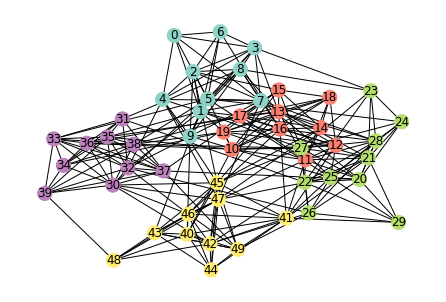

In [26]:
#graph generating
sizes = [10, 10, 10, 10, 10]
# probs = [[0.8, .02, .02, .02], [.02, 0.8, .02, .02], [0.02, 0.02, 0.8, .02], [.02, .02, .02, .8]]
probs = [[.8, .08, .08, .08, .08], [.08, .8, .08, .08, .08], [.08, .08, .8, .08, .08], [.08, .08, .08, .8, .08], [.08, .08, .08, .08, .8]]

true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)
# nx.draw(G, node_size=200)
# plt.figure(figsize=(9,9))
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

In [110]:
posdf.head()
#drl

,X,Y
0,-11.241147,-5.665529
1,-11.672582,-5.720899
2,-11.480559,-6.215538
3,-10.886744,-5.070607
4,-10.705183,-5.287017


In [118]:

posdf.head()

,X,Y
0,2.791096,-23.287638
1,3.167117,-22.995293
2,2.346109,-23.404764
3,2.906820,-24.129900
4,3.575117,-23.140091


In [120]:
max(posdf.Y)

-22.02183723449707

In [3]:
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
layout = G_ig.layout('drl')
# layout = layout.transfom(layout, -1, 1, -1, 1)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
posdf.head()

,X,Y
0,-18.270126,-8.315481
1,-19.022320,-7.886877
2,-18.146606,-7.746658
3,-18.735882,-7.298567
4,-18.528881,-8.423969


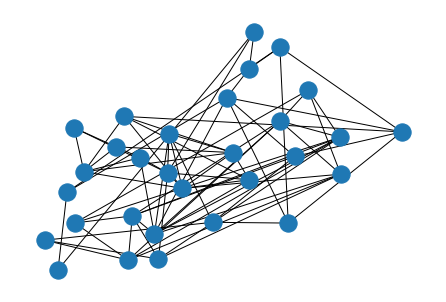

In [11]:
nx.draw(G, layout.coords)

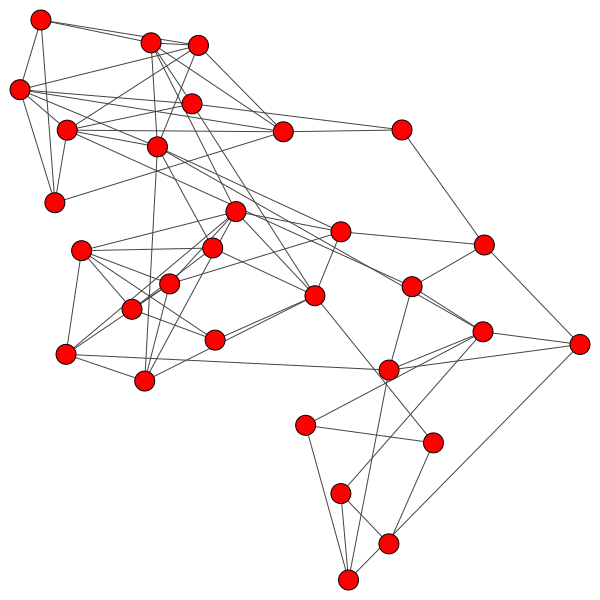

In [6]:
layout = G_ig.layout("drl")
ig.plot(G_ig, layout=layout)

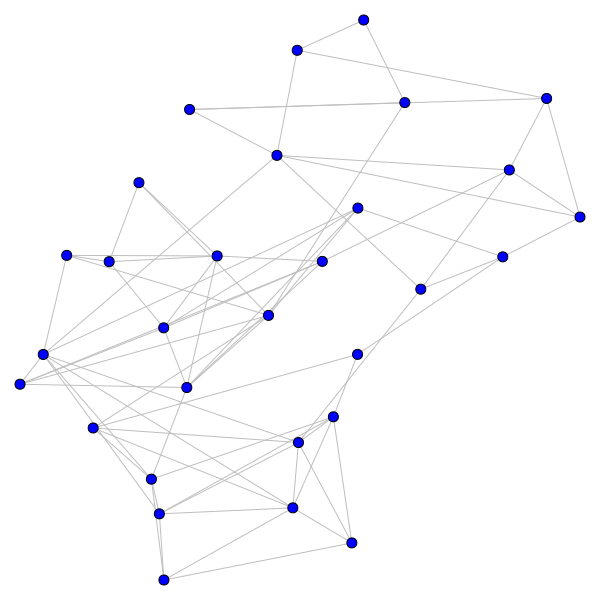

In [23]:
import igraph as ig
import numpy as np
import pandas as pd

# Assuming you have your graph 'G' already created

# Get the layout using the "drl" method
layout = G_ig.layout('drl')

# Extract coordinates from the layout
coords = np.array(layout.coords)

# Rescale coordinates to the range [-1, 1]
min_coords = coords.min(axis=0)
max_coords = coords.max(axis=0)
scaled_coords = 2 * (coords - min_coords) / (max_coords - min_coords) - 1

# Create a DataFrame with rescaled coordinates
pos_df = pd.DataFrame(scaled_coords, columns=['X', 'Y'])

# Create an igraph plot
visual_style = {}
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = 'blue'
visual_style["edge_color"] = 'gray'

ig.plot(G_ig, layout=pos_df.values, **visual_style)

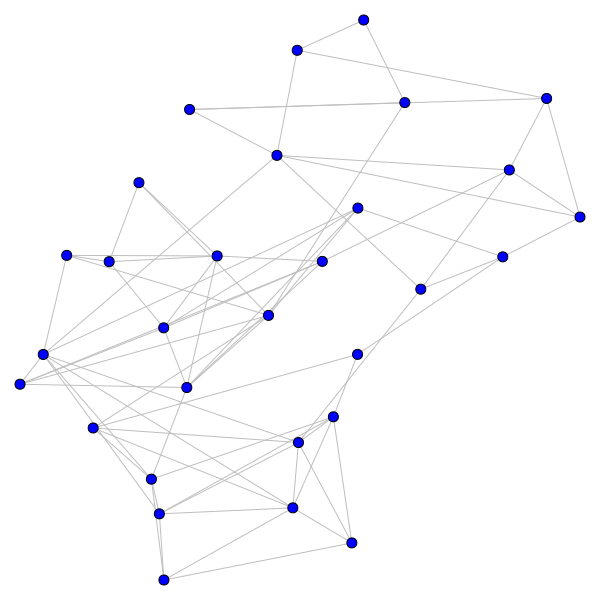

In [25]:
ig.plot(G_ig, layout=layout, **visual_style)

In [22]:
plt.figure(figsize=(8, 6))
ig.plot(G_ig, layout=pos_df.values, vertex_size=10, vertex_color='blue', edge_color='gray')
plt.show()

<Figure size 576x432 with 0 Axes>

In [14]:
min_x = posdf['X'].min()
max_x = posdf['X'].max()
min_y = posdf['Y'].min()
max_y = posdf['Y'].max()

# Rescale X and Y to the range -1 to 1
posdf['X_rescaled'] = ((posdf['X'] - min_x) / (max_x - min_x)) * 2 - 1
posdf['Y_rescaled'] = ((posdf['Y'] - min_y) / (max_y - min_y)) * 2 - 1

# Print the DataFrame with rescaled coordinates
print(posdf.head())
posdf = posdf[["X_rescaled","Y_rescaled"]]

           X         Y  X_rescaled  Y_rescaled
0 -18.270126 -8.315481   -0.070808   -0.336641
1 -19.022320 -7.886877   -0.468780   -0.061930
2 -18.146606 -7.746658   -0.005456    0.027943
3 -18.735882 -7.298567   -0.317231    0.315143
4 -18.528881 -8.423969   -0.207711   -0.406175


In [126]:
pos = nx.spring_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
max(posdf.Y)

0.758783950136536

In [117]:
layout = G_ig.layout('drl')
layout = layout.norm(layout, -1, 1, -1, 1)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])

model = KMeans(n_clusters=best_num)
model.fit(posdf)
yhat = list(model.predict(posdf))
# df['KMeans'] = adjusted_rand_score(true_labels, yhat)
scores.append(adjusted_rand_score(true_labels, yhat))

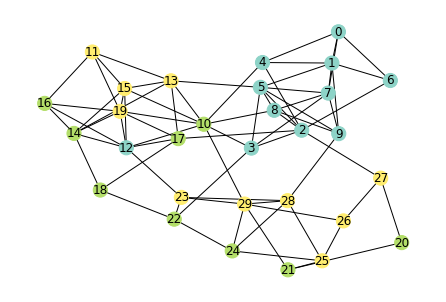

In [106]:
nx.draw(G, pos, node_color=yhat, cmap=plt.cm.Set3, with_labels=True, node_size=200)


In [55]:
layout = G_ig.layout("kamada_kawai")
layout.coords


[[-0.4188608186400238, 2.624436577710109],
 [-0.0600039767476201, 2.080069954285274],
 [-0.7934736699386649, 1.4244695044513205],
 [0.7819038879482912, 2.423955758563377],
 [0.35987862767714507, 1.6406872602124798],
 [-0.4581850012616883, 1.0829309812257522],
 [1.0031536751040926, 1.043673193744985],
 [0.5521916909365489, 0.8771485464716174],
 [0.28580115233680226, 0.160180523922432],
 [-0.009416986059434893, 0.808364192635899],
 [-0.6064358626874189, -0.47863715160926584],
 [2.0429559309677416, 0.8385043458674322],
 [-0.5165541262692153, -0.07399808642090319],
 [0.36922323357031467, -1.2786736765099134],
 [-1.476637129060209, 0.2748822797467263],
 [1.3926911492757466, -0.4727156907349152],
 [-0.9489433004084873, -1.2066741837745698],
 [-1.8164912415571355, -0.3254642117622483],
 [-1.5439150158830472, -0.705637576747416],
 [0.9812421093766832, -0.905586048605354],
 [-2.6671632061499326, -0.11326871734177635],
 [-2.4287788043320155, -1.3447943760837564],
 [-1.7299600580127106, -1.441036

In [52]:
ig.layout_davidson_harel(G_ig)

AttributeError: module 'igraph' has no attribute 'layout_davidson_harel'

In [38]:
print(list_comms)
print(yhat)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [39]:
#metrics
print(f'Community detection: {adjusted_rand_score(true_labels, list_comms)}')
print(f'Clustering: {adjusted_rand_score(true_labels, yhat)}')

Community detection: 0.5538461538461539
Clustering: 1.0


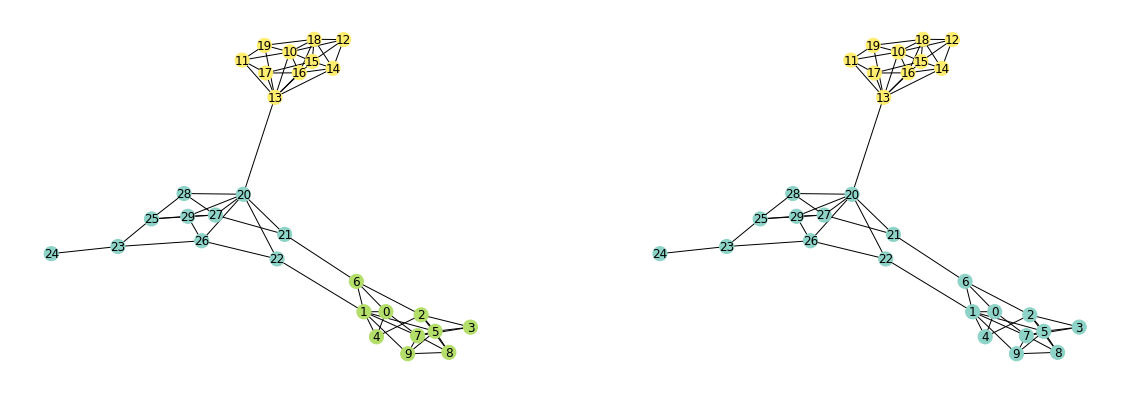

In [21]:
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
nx.draw(G, pos, node_color=yhat, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.subplot(1, 2, 2)
nx.draw(G, pos, node_color=list_comms, cmap=plt.cm.Set3, with_labels=True, node_size=200)

plt.show()

In [11]:
type(yhat)

numpy.ndarray

In [34]:
list(nx.community.girvan_newman(G))

[({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}),
 ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
  {20, 21, 22, 23, 24, 25, 26, 27, 28, 29}),
 ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
  {20, 21, 22, 23, 25, 26, 27, 28, 29},
  {24}),
 ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
  {20, 21, 25, 27, 28, 29},
  {22, 23, 26},
  {24}),
 ({0, 1, 4, 6},
  {2, 3, 5, 7, 8, 9},
  {10, 11, 12, 13, 14, 15, 16, 17, 18, 19},
  {20, 21, 25, 27, 28, 29},
  {22, 23, 26},
  {24}),
 ({0, 1, 4, 6},
  {2, 3, 5, 7, 8, 9},
  {10, 12, 14, 15, 16, 18},
  {11, 13, 17, 19},
  {20, 21, 25, 27, 28, 29},
  {22, 23, 26},
  {24}),
 ({0, 1, 4, 6},
  {2, 3, 5, 7, 8, 9},
  {10, 12, 14, 15, 16, 18},
  {11, 13, 17, 19},
  {20, 25, 27, 28, 29},
  {21},
  {22, 23, 26},
  {24}),
 ({0, 1, 4, 6},
  {2, 5, 7, 8, 9},
  {3},
  {10, 12, 14, 15, 16, 18},
  {11, 13, 17

In [32]:
first_iteration_communities = next(communities)
node_to_community = {}
for i, community in enumerate(first_iteration_communities):
    for node in community:
        node_to_community[node] = i

# Create an array to store the community labels of each node
community_labels = np.zeros(len(G.nodes()), dtype=int)
for node, community_label in node_to_community.items():
    community_labels[node] = community_label

print(community_labels)

[0 0 1 2 0 1 0 1 1 1 3 4 3 4 3 3 3 4 3 4 5 6 7 7 8 5 7 5 5 5]


In [ ]:
#calucaltig te metrics

In [13]:
yhat


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1], dtype=int64)

In [12]:
community_dict

{1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 3: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}